In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.ensemble import IsolationForest

warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_palette("husl")

In [3]:
COL_NAMES = [
    "duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot",
    "num_failed_logins","logged_in","num_compromised","root_shell",
    "su_attempted","num_root","num_file_creations","num_shells",
    "num_access_files","num_outbound_cmds","is_host_login",
    "is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate",
    "same_srv_rate","diff_srv_rate","srv_diff_host_rate",
    "dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
    "dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "label","difficulty_level"
]

In [4]:
train_path = './data/KDDTrain+.txt'
test_path = './data/KDDTest+.txt'

df_train = pd.read_csv(train_path, header=None, names=COL_NAMES)
df_test = pd.read_csv(test_path, header=None, names=COL_NAMES)

print("Training Shape:", df_train.shape)
print("Test Shape:", df_test.shape)

Training Shape: (125973, 43)
Test Shape: (22544, 43)


In [5]:
attack_mapping = {
    'normal': 'normal',
    
    'back': 'DoS','land': 'DoS','neptune': 'DoS','pod': 'DoS',
    'smurf': 'DoS','teardrop': 'DoS','mailbomb': 'DoS',
    'apache2': 'DoS','processtable': 'DoS','udpstorm': 'DoS',
    
    'satan': 'Probe','ipsweep': 'Probe','nmap': 'Probe',
    'portsweep': 'Probe','mscan': 'Probe','saint': 'Probe',
    
    'guess_passwd': 'R2L','ftp_write': 'R2L','imap': 'R2L',
    'phf': 'R2L','multihop': 'R2L','warezmaster': 'R2L',
    'warezclient': 'R2L','spy': 'R2L','xlock': 'R2L',
    'xsnoop': 'R2L','snmpguess': 'R2L','snmpgetattack': 'R2L',
    'httptunnel': 'R2L','sendmail': 'R2L','named': 'R2L',
    
    'buffer_overflow': 'U2R','loadmodule': 'U2R',
    'perl': 'U2R','rootkit': 'U2R','ps': 'U2R',
    'xterm': 'U2R','sqlattack': 'U2R'
}

df_train['attack_class'] = df_train['label'].map(lambda x: attack_mapping.get(x, 'other'))
df_test['attack_class'] = df_test['label'].map(lambda x: attack_mapping.get(x, 'other'))

print(df_train['attack_class'].value_counts())

attack_class
normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64


In [6]:
categorical_features = ['protocol_type','service','flag']
binary_features = ['land','logged_in','is_host_login','is_guest_login']

numerical_features = [
    col for col in COL_NAMES
    if col not in categorical_features + binary_features + ['label','difficulty_level']
]

print("Categorical:", len(categorical_features))
print("Binary:", len(binary_features))
print("Numerical:", len(numerical_features))

Categorical: 3
Binary: 4
Numerical: 34


In [7]:
print(df_train.isnull().sum())

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [8]:
iso_df = df_train[numerical_features].copy()

clf = IsolationForest(
    max_samples='auto',
    contamination=0.01,
    random_state=42
)

outliers = clf.fit_predict(iso_df)

df_train['is_outlier'] = outliers

print("Total Outliers:", (outliers == -1).sum())

Total Outliers: 1256


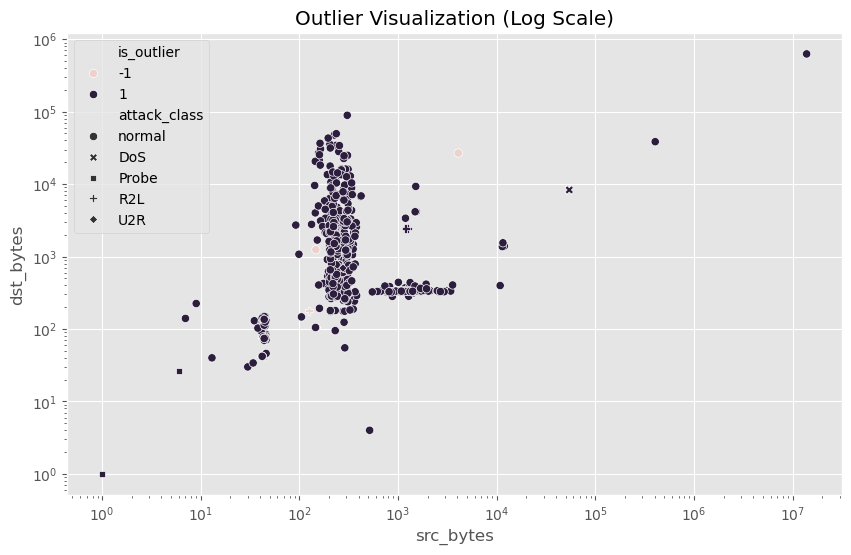

In [9]:
plt.figure(figsize=(10,6))

sns.scatterplot(
    data=df_train[::100],
    x='src_bytes',
    y='dst_bytes',
    hue='is_outlier',
    style='attack_class'
)

plt.xscale('log')
plt.yscale('log')
plt.title("Outlier Visualization (Log Scale)")
plt.show()

In [10]:
def apply_log_transform(df, cols):
    df_transformed = df.copy()

    for col in cols:
        new_col = f"log_{col}"
        df_transformed[new_col] = np.log1p(df_transformed[col])

        fig, ax = plt.subplots(1, 2, figsize=(12,4))

        sns.histplot(df[col], bins=30, kde=True, ax=ax[0])
        ax[0].set_title(f"Original {col}")

        sns.histplot(df_transformed[new_col], bins=30, kde=True, ax=ax[1])
        ax[1].set_title(f"Log Transformed {col}")

        plt.tight_layout()
        plt.show()

    return df_transformed

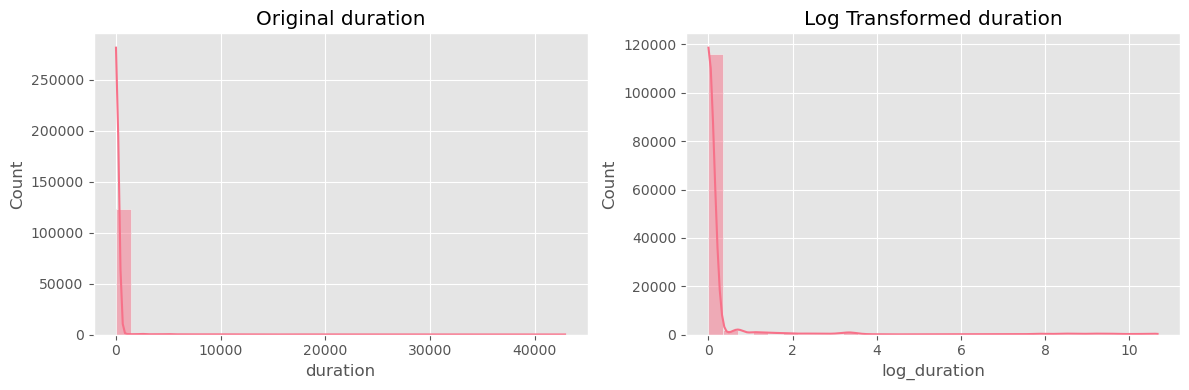

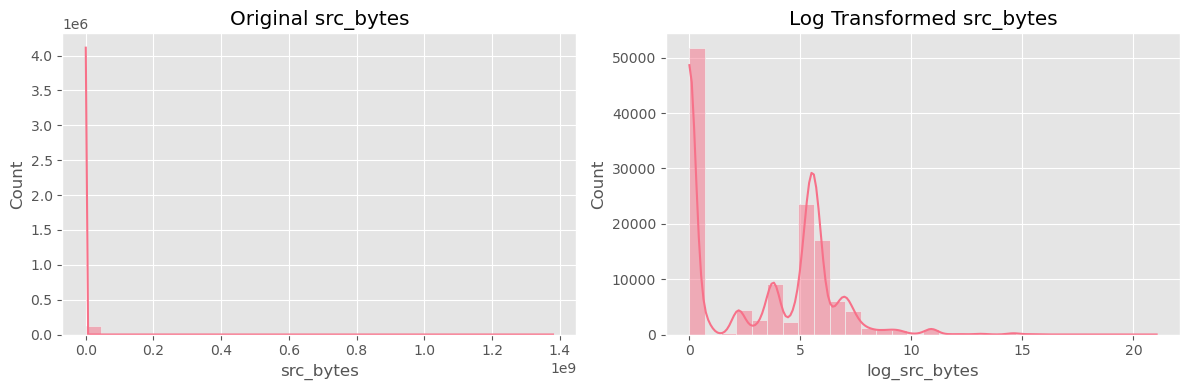

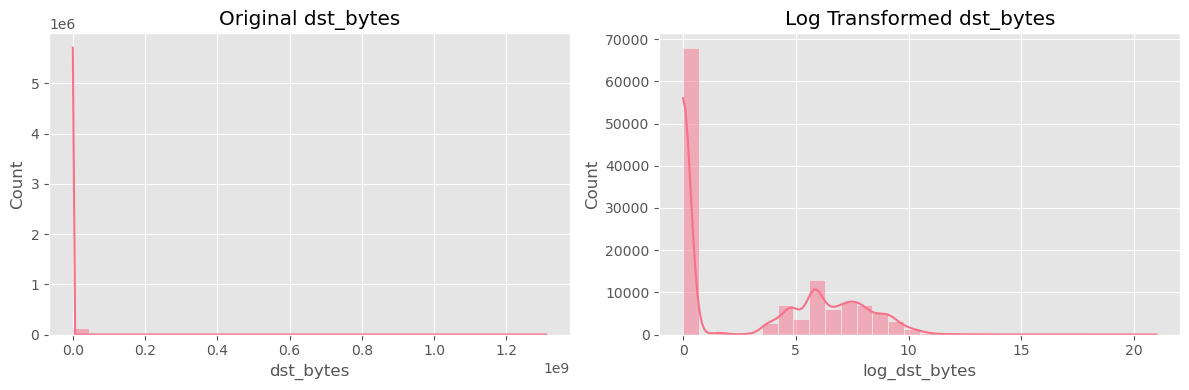

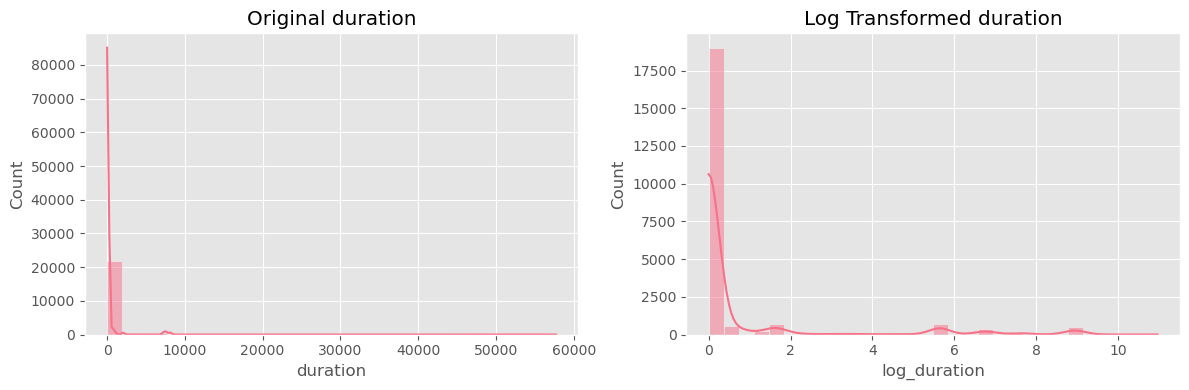

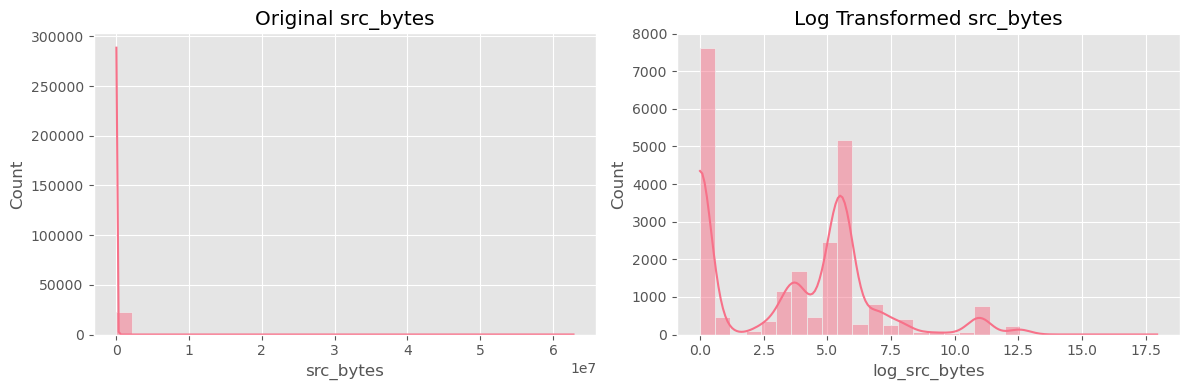

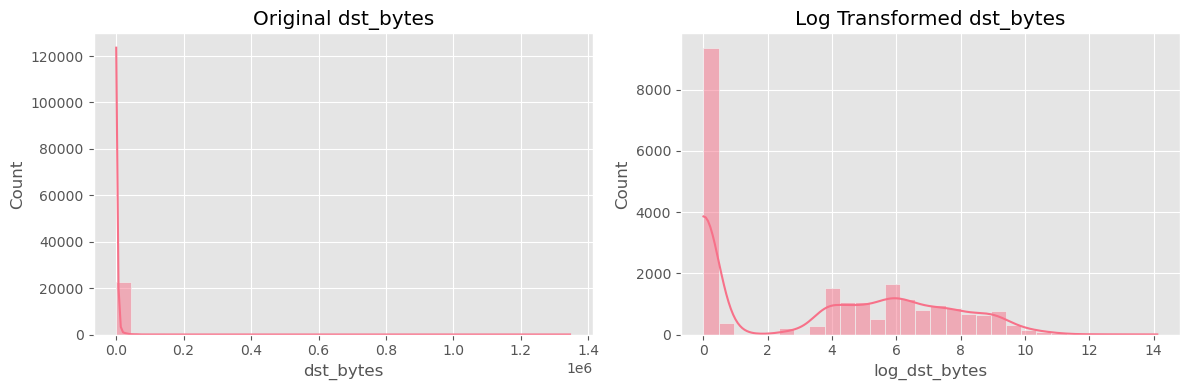

Log Transformation Completed


In [11]:
skewed_cols = ['duration','src_bytes','dst_bytes']

df_train = apply_log_transform(df_train, skewed_cols)
df_test = apply_log_transform(df_test, skewed_cols)

print("Log Transformation Completed")

In [12]:
print(df_train[['log_duration','log_src_bytes','log_dst_bytes']].head())

   log_duration  log_src_bytes  log_dst_bytes
0           0.0       6.198479       0.000000
1           0.0       4.990433       0.000000
2           0.0       0.000000       0.000000
3           0.0       5.451038       9.006264
4           0.0       5.298317       6.042633


In [13]:
log_features = ['log_duration','log_src_bytes','log_dst_bytes']

log_corr = df_train[log_features].corr()

print("Correlation Matrix:")
print(log_corr)

Correlation Matrix:
               log_duration  log_src_bytes  log_dst_bytes
log_duration       1.000000       0.103887        0.08349
log_src_bytes      0.103887       1.000000        0.70235
log_dst_bytes      0.083490       0.702350        1.00000


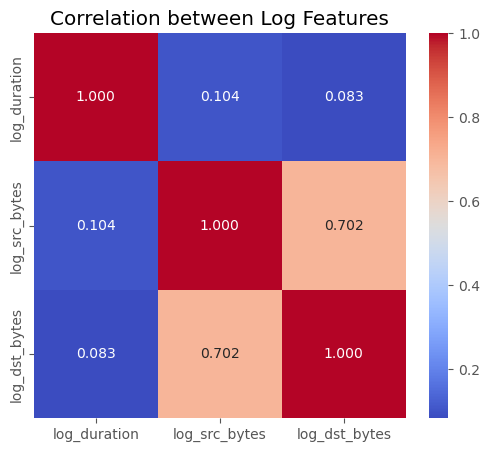

In [14]:
plt.figure(figsize=(6,5))

sns.heatmap(
    log_corr,
    annot=True,
    cmap='coolwarm',
    fmt=".3f"
)

plt.title("Correlation between Log Features")
plt.show()

In [15]:
log_data = df_train[log_features]

log_data.to_csv("log_transformed_values.csv", index=False)

print("CSV file saved successfully!")

CSV file saved successfully!


In [16]:
log_data = df_train[log_features + ['attack_class']]

log_data.to_csv("log_features_with_class.csv", index=False)

print("CSV file saved successfully!")

CSV file saved successfully!


In [17]:
check_csv = pd.read_csv("log_transformed_values.csv")
print(check_csv.head())

   log_duration  log_src_bytes  log_dst_bytes
0           0.0       6.198479       0.000000
1           0.0       4.990433       0.000000
2           0.0       0.000000       0.000000
3           0.0       5.451038       9.006264
4           0.0       5.298317       6.042633


In [20]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    eps = 1e-5
    df['total_bytes'] = df['src_bytes'] + df['dst_bytes']
    df['src_bytes_ratio'] = df['src_bytes'] / (df['total_bytes'] + eps)
    df['packet_rate'] = df['count'] / (df['duration'] + eps)
    df['byte_diff'] = np.abs(df['src_bytes'] - df['dst_bytes'])

    error_flags = {'S0', 'S1', 'S2', 'S3', 'REJ'}
    df['is_error_flag'] = df['flag'].isin(error_flags).astype(np.int8)

    df['same_srv_interaction'] = (
        df['same_srv_rate'] * df['dst_host_same_srv_rate']
    )

    return df

In [21]:
from sklearn.preprocessing import OneHotEncoder

def encode_features(df_train, df_test):
    
    cols_to_encode = ['protocol_type', 'flag']

    ohe = OneHotEncoder(
        sparse_output=False,
        handle_unknown='ignore',
        dtype=np.float32
    )

    ohe_train = pd.DataFrame(
        ohe.fit_transform(df_train[cols_to_encode]),
        columns=ohe.get_feature_names_out(cols_to_encode),
        index=df_train.index
    )

    ohe_test = pd.DataFrame(
        ohe.transform(df_test[cols_to_encode]),
        columns=ohe.get_feature_names_out(cols_to_encode),
        index=df_test.index
    )

    service_freq = df_train['service'].value_counts(normalize=True)
    
    df_train['service_freq'] = df_train['service'].map(service_freq)
    df_test['service_freq'] = df_test['service'].map(service_freq).fillna(0)

    df_train_encoded = pd.concat([df_train, ohe_train], axis=1)
    df_test_encoded = pd.concat([df_test, ohe_test], axis=1)

    drop_cols = ['protocol_type', 'flag', 'service']
    df_train_encoded.drop(columns=drop_cols, inplace=True)
    df_test_encoded.drop(columns=drop_cols, inplace=True)

    df_test_encoded = df_test_encoded.reindex(
        columns=df_train_encoded.columns,
        fill_value=0
    )

    return df_train_encoded, df_test_encoded

In [22]:
df_train = engineer_features(df_train)
df_test = engineer_features(df_test)
df_train_encode, df_test_encode = encode_features(df_train, df_test)

print("Train Shape:", df_train_encode.shape)
print("Test Shape:", df_test_encode.shape)

df_train_encode.head()

Train Shape: (125973, 66)
Test Shape: (22544, 66)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [25]:
drop_cols = ['label', 'attack_class', 'difficulty_level', 'is_outlier']

X_train = df_train_encode.drop(columns=drop_cols)
y_train = df_train_encode['label']

X_test = df_test_encode.drop(columns=drop_cols)
y_test = df_test_encode['label']

In [26]:
print(X_train.dtypes.value_counts())

int64      25
float64    22
float32    14
int8        1
Name: count, dtype: int64


In [27]:
from sklearn.feature_selection import VarianceThreshold

var_selector = VarianceThreshold(threshold=0.0)

X_train_var = var_selector.fit_transform(X_train)
X_test_var = var_selector.transform(X_test)

selected_columns_var = X_train.columns[var_selector.get_support()]

X_train_var = pd.DataFrame(X_train_var, columns=selected_columns_var)
X_test_var = pd.DataFrame(X_test_var, columns=selected_columns_var)

print("After Variance Threshold:", X_train_var.shape)

After Variance Threshold: (125973, 61)


In [28]:
X_train.select_dtypes(include='object')

""
0
1
2
3
4
...
125968
125969
125970
125971


In [35]:
df_train_encode = df_train_encode.drop_duplicates()

print("After removing duplicates:", df_train_encode.shape)

After removing duplicates: (125971, 66)


In [36]:
import numpy as np
corr_matrix = X_train.corr().abs()

upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.90)]

print("Highly Correlated Features:", len(to_drop))

X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

Highly Correlated Features: 12


In [37]:
def remove_outliers_iqr(df, threshold=1.5):
    df_clean = df.copy()
    
    Q1 = df_clean.quantile(0.25)
    Q3 = df_clean.quantile(0.75)
    IQR = Q3 - Q1

    mask = ~((df_clean < (Q1 - threshold * IQR)) | 
             (df_clean > (Q3 + threshold * IQR))).any(axis=1)

    return df_clean[mask]

# Apply only on training data
X_train_clean = remove_outliers_iqr(X_train)

# Align y
y_train_clean = y_train.loc[X_train_clean.index]

print("After Outlier Removal:", X_train_clean.shape)

After Outlier Removal: (39832, 50)


In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_clean, y_train_clean)

importance = pd.Series(rf.feature_importances_, index=X_train_clean.columns)

# Remove very weak features
low_importance = importance[importance < 0.005].index

print("Low Importance Features:", len(low_importance))

X_train_clean = X_train_clean.drop(columns=low_importance)
X_test = X_test.drop(columns=low_importance)

Low Importance Features: 34


In [39]:
print("Final Train Shape:", X_train_clean.shape)
print("Final Test Shape:", X_test.shape)

Final Train Shape: (39832, 16)
Final Test Shape: (22544, 16)
